In [ ]:
!python -m spacy download xx_ent_wiki_sm
!pip install graphviz
!pip install pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 78.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model, clone_model
from keras.layers import Input, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from lvclassify_helpers import getdata10cat, getlvstopwords

#### Datu ielāde, kategorijas vērtības kodēšana

In [ ]:
df = getdata10cat()
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
# Sanity-check kategorijas datu kodējumam
print(df.head(5))
print(df.category.value_counts())
print(df.encod_cat.value_counts())

  category                                               body  encod_cat
0   Sports  Reaģējot uz  Latvijas Paralimpiskās komitejas ...          8
1   Sports  Latvijas tenisiste  Jeļena Ostapenko  šodien Ķ...          8
2   Sports  Latvijas Sporta federāciju padome  (LSFP) iebi...          8
3   Sports  Jaunais sporta finansējuma modelis samazinās f...          8
4   Sports  Aleksandrs  un  Mihails Samoilovi  piektdien S...          8
category
Sports           1200
Politika         1200
Literatūra       1200
Finanses         1200
Atpūta           1200
Kriminālziņas    1200
Kino             1200
Mūzika           1200
Auto             1200
Tehnoloģijas     1200
Name: count, dtype: int64
encod_cat
8    1200
7    1200
5    1200
2    1200
0    1200
4    1200
3    1200
6    1200
1    1200
9    1200
Name: count, dtype: int64


#### Sadalam datus 80/20

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df['body'], df['encod_cat'], test_size=.2, stratify=df['encod_cat'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9600,) (2400,) (9600,) (2400,)


#### Priekšapstrāde, izlīdzinam rindu garumu

In [ ]:
punct = string.punctuation
stopwords_arr = getlvstopwords()

def datu_prieksapstrade(train_sentences):
    return [" ".join([word for word in sentence.lower().split() if word not in stopwords_arr and word not in punct]) for sentence in train_sentences]

vocab_size = 20000
max_len = 512

def datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test, apstrades_funkc=None):
    if apstrades_funkc:
        x_train_ar_apstradi = apstrades_funkc(x_train)
        x_test_ar_apstradi = apstrades_funkc(x_test)
    else:
        x_train_ar_apstradi = x_train.copy()
        x_test_ar_apstradi = x_test.copy()

    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(x_train_ar_apstradi)
    x_seq_train = tokenizer.texts_to_sequences(x_train_ar_apstradi)
    x_seq_test = tokenizer.texts_to_sequences(x_test_ar_apstradi)
    padding_type = 'post'
    x_train_padded = pad_sequences(x_seq_train, padding=padding_type, maxlen=max_len)
    x_test_padded = pad_sequences(x_seq_test, padding=padding_type, maxlen=max_len)

    return x_train_padded, x_test_padded, tokenizer

x_train_ar_apstradi, x_test_ar_apstradi, tokenizer = datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test, apstrades_funkc=datu_prieksapstrade)
x_train_bez_apstrades, x_test_bez_apstrades, tokenizer = datu_prieksapstrade_tokenizacija_izlidzinasana(x_train, x_test)


#### Neironu tīkla izveide ar LSTM slāni - bāzes modelis

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 512)          10240000  
                                                                 
 spatial_dropout1d (Spatial  (None, 512, 512)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 11030026 (42.08 MB)
Trainable params: 11030026 (42.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


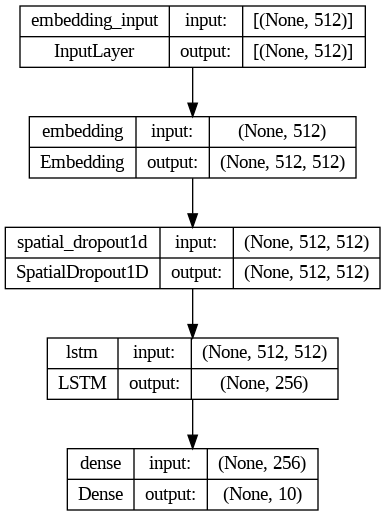

In [ ]:
def lstm_modelis(embedding_dim, fastTextSvari=None, bidirectional=False):
    model = tf.keras.Sequential()

    if fastTextSvari is not None:
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[fastTextSvari], trainable=False))
    else:
        model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

    model.add(SpatialDropout1D(0.2))

    if bidirectional:
        model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
    else:
        model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))

    model.add(tf.keras.layers.Dense(df['category'].nunique(), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model_base_ar_apstradi = lstm_modelis(512)
model_base_ar_apstradi.summary()
plot_model(model_base_ar_apstradi, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Divvirzienu LSTM modelis (BiLSTM)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 512)          10240000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 512, 512)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 512)               1574912   
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 11820042 (45.09 MB)
Trainable params: 11820042 (45.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


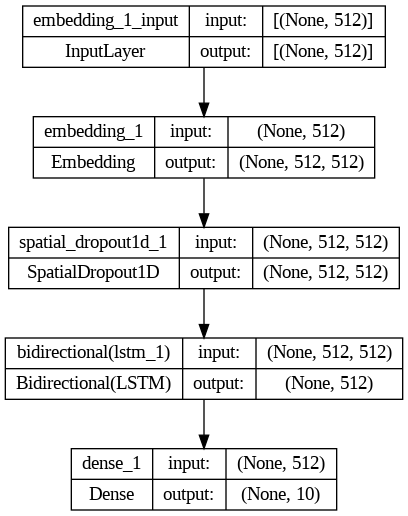

In [ ]:
model_bi_directional = lstm_modelis(512, bidirectional=True)
model_bi_directional.summary()
plot_model(model_bi_directional, to_file='model_plot_LSTM_bi_directional.png', show_shapes=True, show_layer_names=True)

Izveidojam kopijas pirms apmācības, pārbaudei ar apstrādātiem / neapstrādātiem rakstiem

In [ ]:
model_base_bez_apstrades = lstm_modelis(512)
model_bi_directional_bez_apstrades = lstm_modelis(512, bidirectional=True)

#### Apmācam neironu tīklus 20 epohos

In [ ]:
%%time
rezultats_ar_apstradi = model_base_ar_apstradi.fit(x_train_ar_apstradi, y_train, epochs=20,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_ar_apstradi.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)])

Epoch 1/20
300/300 [==============================] - 235s 776ms/step - loss: 2.2617 - accuracy: 0.1392 - val_loss: 2.2255 - val_accuracy: 0.1421
Epoch 2/20
300/300 [==============================] - 233s 777ms/step - loss: 2.1099 - accuracy: 0.1820 - val_loss: 1.9640 - val_accuracy: 0.2254
Epoch 3/20
300/300 [==============================] - 232s 773ms/step - loss: 1.9963 - accuracy: 0.2323 - val_loss: 2.1490 - val_accuracy: 0.1692
Epoch 4/20
300/300 [==============================] - 232s 775ms/step - loss: 1.8693 - accuracy: 0.2546 - val_loss: 1.9792 - val_accuracy: 0.2221
Epoch 5/20
300/300 [==============================] - 232s 774ms/step - loss: 1.7959 - accuracy: 0.2735 - val_loss: 2.3552 - val_accuracy: 0.1758
Epoch 6/20
300/300 [==============================] - 233s 778ms/step - loss: 1.7885 - accuracy: 0.2817 - val_loss: 1.9024 - val_accuracy: 0.2325
Epoch 7/20
300/300 [==============================] - 232s 774ms/step - loss: 1.7065 - accuracy: 0.2905 - val_loss: 1.9447 -

In [ ]:
model_base_bez_apstrades = lstm_modelis(512)

In [ ]:
%%time
rezultats_bez_apstrades = model_base_bez_apstrades.fit(x_train_bez_apstrades, y_train, epochs=20,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_bez_apstrades.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)])

Epoch 1/20
300/300 [==============================] - 236s 778ms/step - loss: 2.2467 - accuracy: 0.1492 - val_loss: 2.2001 - val_accuracy: 0.1571
Epoch 2/20
300/300 [==============================] - 234s 780ms/step - loss: 2.1216 - accuracy: 0.1890 - val_loss: 2.1701 - val_accuracy: 0.1758
Epoch 3/20
300/300 [==============================] - 234s 780ms/step - loss: 1.9982 - accuracy: 0.2377 - val_loss: 2.1414 - val_accuracy: 0.1896
Epoch 4/20
300/300 [==============================] - 233s 777ms/step - loss: 1.8893 - accuracy: 0.2709 - val_loss: 1.7849 - val_accuracy: 0.2717
Epoch 5/20
300/300 [==============================] - 233s 776ms/step - loss: 1.6697 - accuracy: 0.3527 - val_loss: 1.8688 - val_accuracy: 0.2925
Epoch 6/20
300/300 [==============================] - 233s 777ms/step - loss: 1.7357 - accuracy: 0.3607 - val_loss: 1.9075 - val_accuracy: 0.3617
Epoch 7/20
300/300 [==============================] - 233s 778ms/step - loss: 0.9618 - accuracy: 0.6273 - val_loss: 0.8676 -

In [ ]:
model_bi_directional = lstm_modelis(512, bidirectional=True)

In [ ]:
%%time
rezultats_bi_directional_ar_apstradi = model_bi_directional.fit(x_train_ar_apstradi, y_train, epochs=20,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_bi_directional_ar_apstradi.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)])

Epoch 1/20
300/300 [==============================] - 329s 1s/step - loss: 1.1415 - accuracy: 0.6109 - val_loss: 0.5418 - val_accuracy: 0.8300
Epoch 2/20
300/300 [==============================] - 325s 1s/step - loss: 0.2591 - accuracy: 0.9317 - val_loss: 0.2804 - val_accuracy: 0.9221
Epoch 3/20
300/300 [==============================] - 324s 1s/step - loss: 0.0863 - accuracy: 0.9772 - val_loss: 0.2438 - val_accuracy: 0.9304
Epoch 4/20
300/300 [==============================] - 323s 1s/step - loss: 0.0240 - accuracy: 0.9946 - val_loss: 0.2839 - val_accuracy: 0.9221
Epoch 5/20
300/300 [==============================] - 324s 1s/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.3096 - val_accuracy: 0.9171
Epoch 6/20
300/300 [==============================] - 323s 1s/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.2710 - val_accuracy: 0.9396
Epoch 7/20
300/300 [==============================] - 323s 1s/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.2957 - val_accuracy: 0.9375

In [ ]:
%%time
rezultats_bi_directional_bez_apstrades = model_bi_directional_bez_apstrades.fit(x_train_bez_apstrades, y_train, epochs=20,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                                                 callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_bi_directional_bez_apstrades.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)])

Epoch 1/20
300/300 [==============================] - 332s 1s/step - loss: 1.2435 - accuracy: 0.5691 - val_loss: 0.6906 - val_accuracy: 0.7425
Epoch 2/20
300/300 [==============================] - 329s 1s/step - loss: 0.3972 - accuracy: 0.8799 - val_loss: 0.3777 - val_accuracy: 0.8821
Epoch 3/20
300/300 [==============================] - 326s 1s/step - loss: 0.1147 - accuracy: 0.9675 - val_loss: 0.3400 - val_accuracy: 0.9000
Epoch 4/20
300/300 [==============================] - 325s 1s/step - loss: 0.0425 - accuracy: 0.9890 - val_loss: 0.3627 - val_accuracy: 0.9008
Epoch 5/20
300/300 [==============================] - 325s 1s/step - loss: 0.0241 - accuracy: 0.9941 - val_loss: 0.3412 - val_accuracy: 0.9137
Epoch 6/20
300/300 [==============================] - 325s 1s/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 0.3423 - val_accuracy: 0.9162
Epoch 7/20
300/300 [==============================] - 325s 1s/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.3250 - val_accuracy: 0.9312

#### Iegūto modeļu novērtējums, apmācības vizualizācija

75/75 [==============================] - 15s 200ms/step
              precision    recall  f1-score   support

           0     0.9585    0.9625    0.9605       240
           1     0.9365    0.9833    0.9593       240
           2     0.9124    0.8250    0.8665       240
           3     0.9590    0.9750    0.9669       240
           4     0.9498    0.9458    0.9478       240
           5     0.9344    0.9500    0.9421       240
           6     0.9870    0.9500    0.9682       240
           7     0.9524    0.9167    0.9342       240
           8     0.9309    0.9542    0.9424       240
           9     0.8157    0.8667    0.8404       240

    accuracy                         0.9329      2400
   macro avg     0.9337    0.9329    0.9328      2400
weighted avg     0.9337    0.9329    0.9328      2400



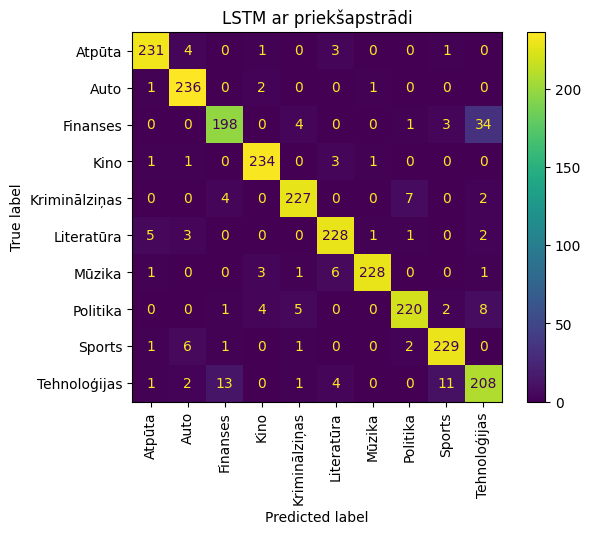

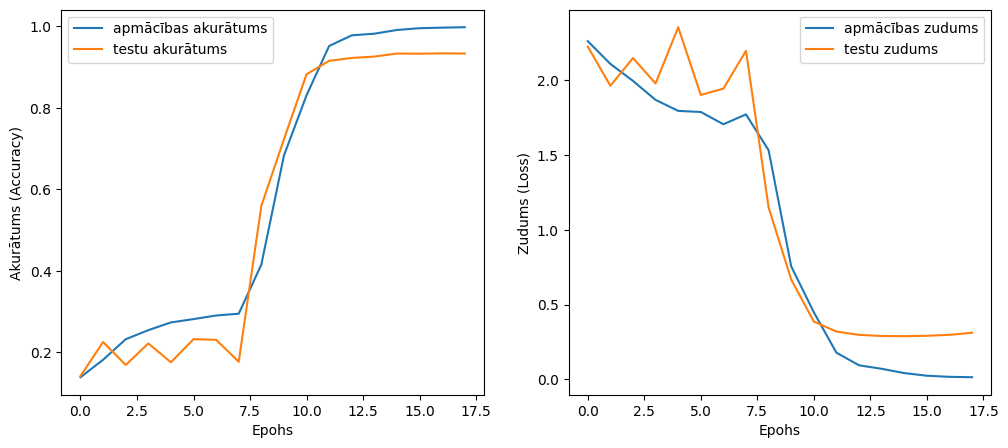

75/75 [==============================] - 15s 200ms/step
              precision    recall  f1-score   support

           0     0.9544    0.9583    0.9563       240
           1     0.9553    0.9792    0.9671       240
           2     0.8856    0.8708    0.8782       240
           3     0.9915    0.9708    0.9811       240
           4     0.9467    0.9625    0.9545       240
           5     0.9295    0.9333    0.9314       240
           6     0.9585    0.9625    0.9605       240
           7     0.8884    0.9292    0.9084       240
           8     0.9555    0.9833    0.9692       240
           9     0.8991    0.8167    0.8559       240

    accuracy                         0.9367      2400
   macro avg     0.9364    0.9367    0.9363      2400
weighted avg     0.9364    0.9367    0.9363      2400



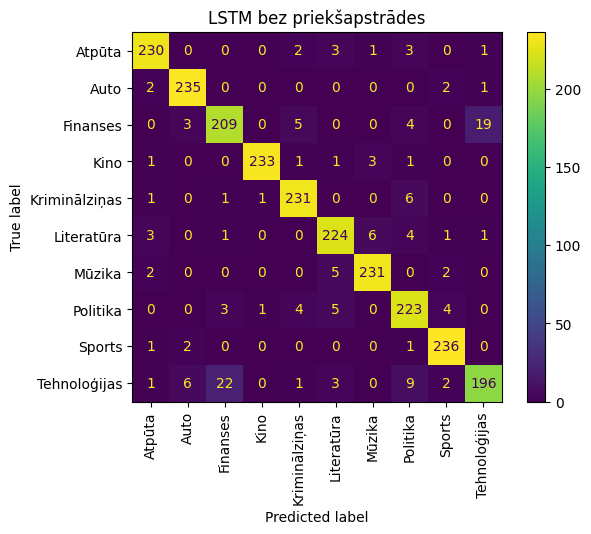

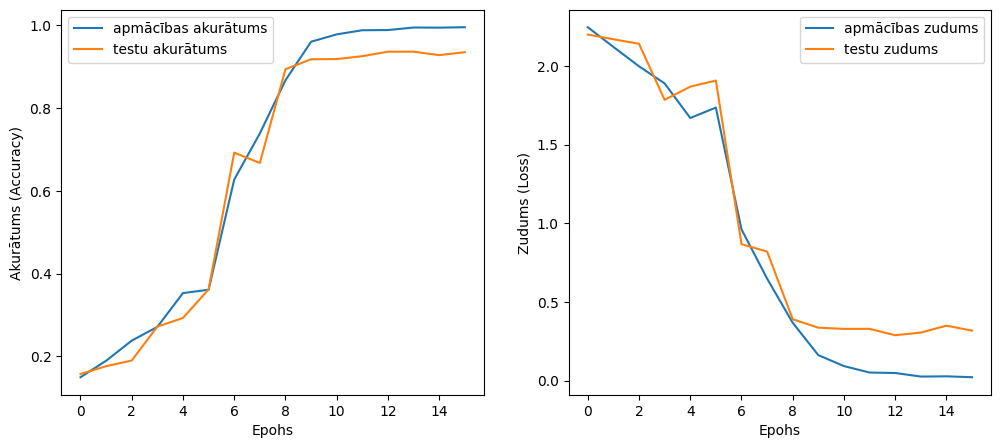

75/75 [==============================] - 19s 252ms/step
              precision    recall  f1-score   support

           0     0.9286    0.9750    0.9512       240
           1     0.9580    0.9500    0.9540       240
           2     0.8879    0.8583    0.8729       240
           3     0.9363    0.9792    0.9572       240
           4     0.9696    0.9292    0.9489       240
           5     0.9524    0.9167    0.9342       240
           6     0.9538    0.9458    0.9498       240
           7     0.8889    0.9333    0.9106       240
           8     0.9634    0.9875    0.9753       240
           9     0.8652    0.8292    0.8468       240

    accuracy                         0.9304      2400
   macro avg     0.9304    0.9304    0.9301      2400
weighted avg     0.9304    0.9304    0.9301      2400



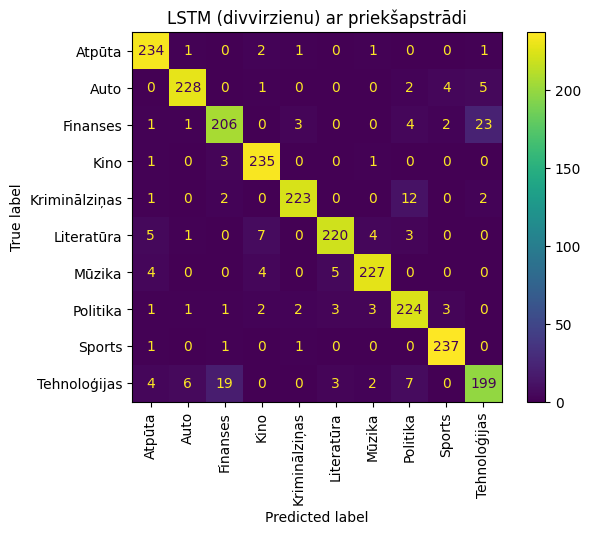

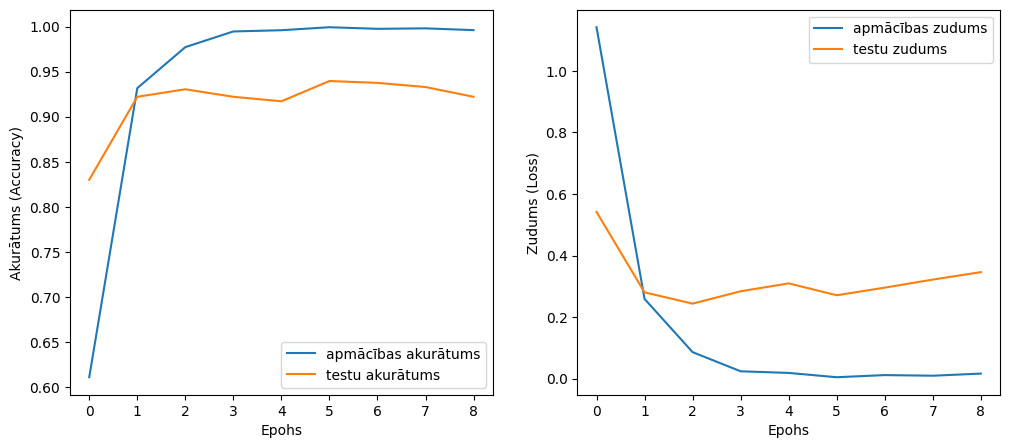

75/75 [==============================] - 19s 250ms/step
              precision    recall  f1-score   support

           0     0.9141    0.9750    0.9435       240
           1     0.9824    0.9292    0.9550       240
           2     0.8884    0.8292    0.8578       240
           3     0.9671    0.9792    0.9731       240
           4     0.9458    0.9458    0.9458       240
           5     0.9283    0.9167    0.9224       240
           6     0.9395    0.9708    0.9549       240
           7     0.9177    0.9292    0.9234       240
           8     0.9747    0.9625    0.9686       240
           9     0.8571    0.8750    0.8660       240

    accuracy                         0.9313      2400
   macro avg     0.9315    0.9313    0.9311      2400
weighted avg     0.9315    0.9313    0.9311      2400



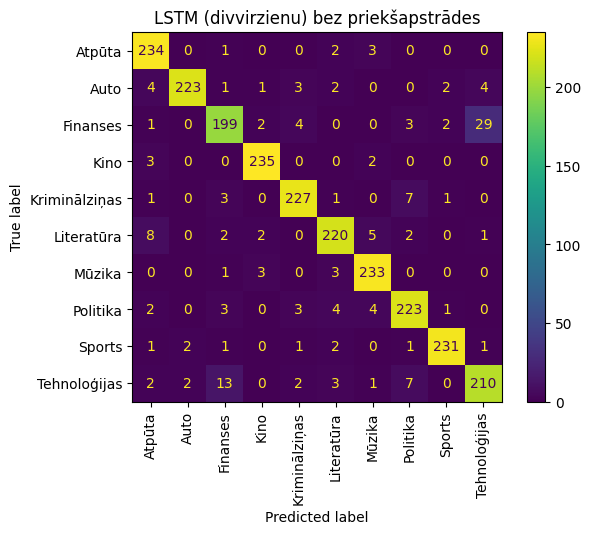

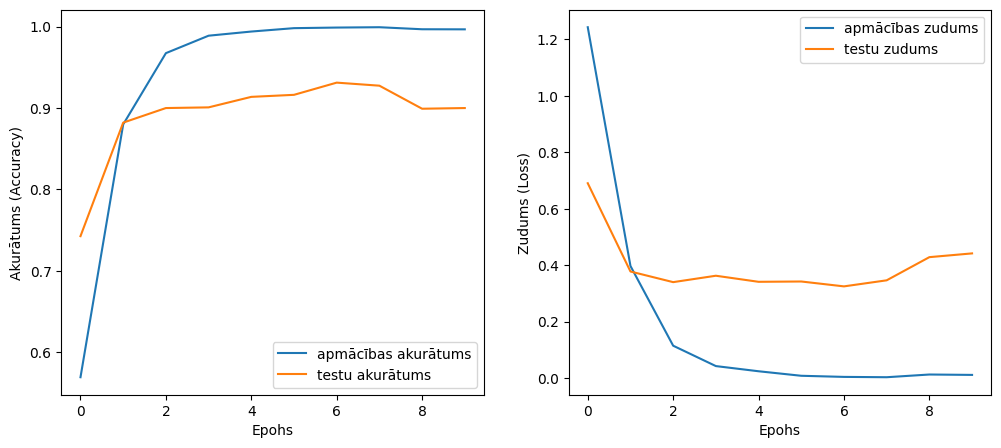

In [ ]:
def modela_novertesana(model, x_test_val, y_test_val, title):
    y_pred = model.predict(x_test_val)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test_val, y_pred)

    labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
    plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plot.plot(xticks_rotation=90)
    plot.ax_.set_title(title)

    print(classification_report(y_test, y_pred, digits=4))

def plot_apmacibas_rezultats(rezultats):
    plt.figure(figsize=(12, 5))

    ax = plt.subplot(121)
    plt.plot(rezultats.history['accuracy'])
    plt.plot(rezultats.history['val_accuracy'])
    plt.xlabel("Epohs")
    plt.ylabel("Akurātums (Accuracy)")
    plt.legend(['apmācības akurātums', 'testu akurātums'])

    plt.subplot(122)
    plt.plot(rezultats.history['loss'])
    plt.plot(rezultats.history['val_loss'])
    plt.xlabel("Epohs")
    plt.ylabel("Zudums (Loss)")
    plt.legend(['apmācības zudums', 'testu zudums'])

    plt.show()

# Ielādējam svarus no epoha ar mazāko validācijas zuduma vērtību
model_base_ar_apstradi.load_weights('./drive/MyDrive/models/LSTM_model_ar_apstradi.h5')
model_base_bez_apstrades.load_weights('./drive/MyDrive/models/LSTM_model_bez_apstrades.h5')
model_bi_directional.load_weights('./drive/MyDrive/models/LSTM_model_bi_directional_ar_apstradi.h5')
model_bi_directional_bez_apstrades.load_weights('./drive/MyDrive/models/LSTM_model_bi_directional_bez_apstrades.h5')

modela_novertesana(model_base_ar_apstradi, x_test_ar_apstradi, y_test, "LSTM ar priekšapstrādi")
plot_apmacibas_rezultats(rezultats_ar_apstradi)
modela_novertesana(model_base_bez_apstrades, x_test_bez_apstrades, y_test, "LSTM bez priekšapstrādes")
plot_apmacibas_rezultats(rezultats_bez_apstrades)
modela_novertesana(model_bi_directional, x_test_ar_apstradi, y_test, "LSTM (divvirzienu) ar priekšapstrādi")
plot_apmacibas_rezultats(rezultats_bi_directional_ar_apstradi)
modela_novertesana(model_bi_directional_bez_apstrades, x_test_bez_apstrades, y_test, "LSTM (divvirzienu) bez priekšapstrādes")
plot_apmacibas_rezultats(rezultats_bi_directional_bez_apstrades)


### Pārbaude ar dažādiem datu kopā neiekļautiem rakstiem

In [ ]:
def getLabel(index):
    labels = ['Atpūta', 'Auto', 'Finanses', 'Kino', 'Kriminālziņas', 'Literatūra', 'Mūzika', 'Politika', 'Sports', 'Tehnoloģijas']
    return labels[index]

In [ ]:
def predict(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=512)
    prediction = model_base_bez_apstrades.predict(padded)
    predictionList = prediction.tolist()[0]
    labeled_predictions = [{getLabel(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictionList)]
    return labeled_predictions

In [ ]:
# Politika
predict("""Pirmdien, 4. septembrī, premjera amatam nominētā Evika Siliņa (JV) sāks nākamās koalīcijas sarunas, dalot ministru amatus "Jaunās Vienotības", Zaļo un zemnieku savienības (ZZS) un partijas "Progresīvie" starpā.

Piektdien, 1. septembrī, Siliņa preses konferencē informēja, ka, "Apvienotajam sarakstam" nepiekrītot darboties nākamajā koalīcijā, tajā darbosies trīs politiskie spēki, kuriem Saeimā kopumā ir 52 balsis.

Siliņa gan neizslēdza iespēju, ka ar laiku koalīcijai varētu pievienoties vēl kāds partneris. "Vienmēr pastāv iespēja iegūt vairāk balsis, ja labi strādā," teica Siliņa.

Kā viens no potenciālajiem nākamās koalīcijas atbalstītājiem varētu būt pie frakcijām nepiederošais Oļegs Burovs, ar kuru Siliņa gan neesot runājusi, bet to darot cits nākamās koalīcijas partneris.""")

1/1 [==============================] - 0s 324ms/step


[{'Atpūta': '0.01%'},
 {'Auto': '0.13%'},
 {'Finanses': '31.59%'},
 {'Kino': '0.61%'},
 {'Kriminālziņas': '16.83%'},
 {'Literatūra': '0.05%'},
 {'Mūzika': '0.22%'},
 {'Politika': '50.35%'},
 {'Sports': '0.18%'},
 {'Tehnoloģijas': '0.03%'}]

In [ ]:
# Tehnoloģijas
predict("""Starptautiskais pašapkalpošanās un automatizācijas risinājumu ražotājs "Omnic" Liepājā būvēs jaunu rūpnīcu, lai ražotu pakomātus Eiropas tirgum, liecina uzņēmuma sniegtā informācija.

Šobrīd vēl tiek precizēta potenciāli vislabākā atrašanās vieta ražotnei, bet pirmie būvdarbi varētu tikt uzsākti jau šogad.

Darbu jaunā rūpnīca varētu sākt 2024. gadā.

Kā norāda uzņēmumā, šobrīd vēl esot grūti pateikt precīzas Liepājas rūpnīcas izmaksas, bet līdzīgā ražotnē Gruzijā "Omnic" investēja 8 miljonus eiro.

Liepājas rūpnīcā plānots ražot paku skapīšus, pašapkalpošanās kases aparātus, ar saules paneļiem aprīkotus pakomātus, paku skapīšus-ledusskapjus, kā arī dažādus citus pašapkalpošanās un automatizācijas risinājumus.""")

1/1 [==============================] - 0s 111ms/step


[{'Atpūta': '0.23%'},
 {'Auto': '0.03%'},
 {'Finanses': '0.05%'},
 {'Kino': '0.01%'},
 {'Kriminālziņas': '0.13%'},
 {'Literatūra': '14.71%'},
 {'Mūzika': '0.00%'},
 {'Politika': '16.25%'},
 {'Sports': '0.06%'},
 {'Tehnoloģijas': '68.54%'}]

In [ ]:
# Kriminālziņas
predict("""Aizvadītajā diennaktī valstī reģistrēti 136 ceļu satiksmes negadījumi, tajos cietušas 13 personas, liecina Valsts policijas apkopotie dati.

Četri no cietušajiem bijuši gājēji, tāpat cietis viens velosipēdists un viens elektrisko skrejriteņu vadītājs.

Kopumā ceļu satiksmes jomā pieņemti 456 administratīvo pārkāpumu lēmumi, tajā skaitā 195 par ātruma pārsniegšanu un viens par agresīvu braukšanu.""")

1/1 [==============================] - 0s 112ms/step


[{'Atpūta': '0.00%'},
 {'Auto': '0.00%'},
 {'Finanses': '0.00%'},
 {'Kino': '4.48%'},
 {'Kriminālziņas': '95.51%'},
 {'Literatūra': '0.00%'},
 {'Mūzika': '0.00%'},
 {'Politika': '0.00%'},
 {'Sports': '0.00%'},
 {'Tehnoloģijas': '0.00%'}]

In [ ]:
# Sports
predict("""Serbijas tenisists Novaks Džokovičs piektdien ASV atklātā čempionāta trešās kārtas spēlē pret savu tautieti Laslo Džeri zaudēja pirmajos divos setos, tomēr atspēlējās un svinēja uzvaru.

Ranga vicelīderis Džokovičs ATP 38.numuru Džeri vairāk nekā trīsarpus stundu cīņā uzvarēja ar rezultātu 4-6, 4-6, 6-1, 6-1, 6-3.

Kopš 2007.gada Džokovičs visos "US Open" turnīros, kuros piedalījies, ticis tālāk par trešo kārtu, 2011., 2015. un 2018.gadā kļūstot par čempionu.

"Esmu parādījis, ka varu aizvadīt arī piecu setu mačus. Atspēlēšanās pēc diviem zaudētiem setiem rāda skaidru signālu maniem nākamajiem pretiniekiem, taču nav tā, ka vēlējos nonākt šādā situācijā. Labprāt uzvarētu trīs setos," pēc uzvaras teica Džokovičs.""")

1/1 [==============================] - 0s 116ms/step


[{'Atpūta': '0.03%'},
 {'Auto': '1.42%'},
 {'Finanses': '0.00%'},
 {'Kino': '0.00%'},
 {'Kriminālziņas': '0.05%'},
 {'Literatūra': '0.01%'},
 {'Mūzika': '0.20%'},
 {'Politika': '0.01%'},
 {'Sports': '98.27%'},
 {'Tehnoloģijas': '0.01%'}]

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.lv.300.bin.gz

--2024-05-22 17:32:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.lv.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4106747743 (3.8G) [application/octet-stream]
Saving to: ‘cc.lv.300.bin.gz’

cc.lv.300.bin.gz    100%[===================>]   3.82G   311MB/s    in 13s     

2024-05-22 17:32:21 (300 MB/s) - ‘cc.lv.300.bin.gz’ saved [4106747743/4106747743]



In [ ]:
from gensim.models import fasttext
import logging
import numpy as np
logging.getLogger('gensim').setLevel(logging.ERROR)
vect_ft = fasttext.load_facebook_vectors('cc.lv.300.bin.gz')

vocab_size = len(vect_ft.key_to_index)
embedding_dim = vect_ft.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    try:
        embedding_vector = vect_ft[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
model_base_ar_apstradi_ft = lstm_modelis(300, fastTextSvari=embedding_matrix)
model_base_bez_apstrades_ft = lstm_modelis(300, fastTextSvari=embedding_matrix)
model_bi_directional_ar_apstradi_ft = lstm_modelis(300, fastTextSvari=embedding_matrix, bidirectional=True)
model_bi_directional_bez_apstrades_ft = lstm_modelis(300, fastTextSvari=embedding_matrix, bidirectional=True)

In [ ]:
%%time
rezultats_ar_apstradi_ft = model_base_ar_apstradi_ft.fit(x_train_ar_apstradi, y_train, epochs=50,  batch_size = 32, validation_data=(x_test_ar_apstradi, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_ar_apstradi_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/50
300/300 [==============================] - 187s 618ms/step - loss: 2.2726 - accuracy: 0.1311 - val_loss: 2.2681 - val_accuracy: 0.1304
Epoch 2/50
300/300 [==============================] - 178s 593ms/step - loss: 2.2570 - accuracy: 0.1341 - val_loss: 2.2716 - val_accuracy: 0.1225
Epoch 3/50
300/300 [==============================] - 187s 623ms/step - loss: 2.2534 - accuracy: 0.1429 - val_loss: 2.2653 - val_accuracy: 0.1342
Epoch 4/50
300/300 [==============================] - 178s 594ms/step - loss: 2.2400 - accuracy: 0.1405 - val_loss: 2.2654 - val_accuracy: 0.1221
Epoch 5/50
300/300 [==============================] - 186s 619ms/step - loss: 2.2289 - accuracy: 0.1439 - val_loss: 2.2651 - val_accuracy: 0.1367
Epoch 6/50
300/300 [==============================] - 187s 623ms/step - loss: 2.2214 - accuracy: 0.1509 - val_loss: 2.2526 - val_accuracy: 0.1425
Epoch 7/50
300/300 [==============================] - 178s 593ms/step - loss: 2.2092 - accuracy: 0.1568 - val_loss: 2.2630 -

In [ ]:
%%time
rezultats_bez_apstrades_ft = model_base_bez_apstrades_ft.fit(x_train_bez_apstrades, y_train, epochs=50,  batch_size = 32, validation_data=(x_test_bez_apstrades, y_test), verbose=1,
                           callbacks=[ModelCheckpoint(filepath='./drive/MyDrive/models/LSTM_model_bez_apstrades_ft.h5',save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
                                      EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/50
300/300 [==============================] - 187s 617ms/step - loss: 2.2487 - accuracy: 0.1424 - val_loss: 2.2429 - val_accuracy: 0.1504
Epoch 2/50
300/300 [==============================] - 188s 626ms/step - loss: 2.1846 - accuracy: 0.1675 - val_loss: 2.1850 - val_accuracy: 0.1800
Epoch 3/50
300/300 [==============================] - 188s 626ms/step - loss: 2.1454 - accuracy: 0.1836 - val_loss: 1.8332 - val_accuracy: 0.2237
Epoch 4/50
300/300 [==============================] - 178s 595ms/step - loss: 1.9902 - accuracy: 0.2114 - val_loss: 2.1748 - val_accuracy: 0.1658
Epoch 5/50
300/300 [==============================] - 179s 596ms/step - loss: 2.0935 - accuracy: 0.1999 - val_loss: 2.1941 - val_accuracy: 0.1633
Epoch 6/50
300/300 [==============================] - 179s 596ms/step - loss: 2.2022 - accuracy: 0.1817 - val_loss: 2.1857 - val_accuracy: 0.1729
Epoch 7/50
300/300 [==============================] - 179s 596ms/step - loss: 2.2391 - accuracy: 0.1513 - val_loss: 2.2194 -